<a href="https://colab.research.google.com/github/nkilaru213/a1-distrib/blob/main/assignment1_problem4_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4: MLE for Energy-Based Models with Langevin Sampling

## Part 1: Langevin Sampling

In [1]:
import torch
import matplotlib.pyplot as plt

# Langevin sampler
def langevin_sampler(f, x0, eps=0.1, n_steps=100):
    x = x0.clone().detach().requires_grad_(True)
    samples = []

    for _ in range(n_steps):
        f_x = f(x)
        grad = torch.autograd.grad(f_x.sum(), x)[0]
        noise = torch.randn_like(x)
        x = x + (eps / 2) * grad + torch.sqrt(torch.tensor(eps)) * noise
        x = x.detach().requires_grad_(True)
        samples.append(x.detach().clone())

    return torch.stack(samples)


## Part 2: Define Energy-Based Model

In [2]:
class SimpleEBM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

model = SimpleEBM()
def f(x): return model(x)


## Part 3: MLE Training

In [3]:
def mle_loss(model, data_samples, langevin_samples):
    f_data = model(data_samples).mean()
    f_model = model(langevin_samples).mean()
    return f_model - f_data

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Simulate toy data
data = torch.randn(512, 2) * 1.5

for epoch in range(200):
    x0 = torch.randn_like(data)
    samples = langevin_sampler(f, x0, n_steps=50)
    samples = samples[-1]

    loss = mle_loss(model, data, samples)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.1141
Epoch 20, Loss: -0.1091
Epoch 40, Loss: -0.2213
Epoch 60, Loss: -0.1679
Epoch 80, Loss: -0.1550
Epoch 100, Loss: -0.1155
Epoch 120, Loss: -0.0343
Epoch 140, Loss: -0.0349
Epoch 160, Loss: -0.0520
Epoch 180, Loss: 0.0069


## Part 4: Visualization

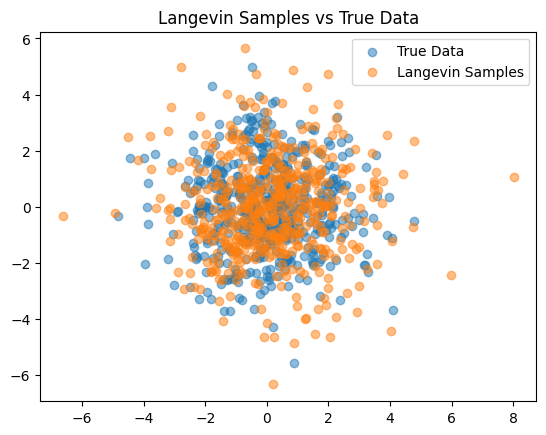

In [4]:
# Plot comparison between true data and model samples
plt.scatter(data[:, 0], data[:, 1], label='True Data', alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], label='Langevin Samples', alpha=0.5)
plt.legend()
plt.title("Langevin Samples vs True Data")
plt.show()
